In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import shap

# 載入數據
df = pd.read_csv("D:/創新提案/Data/loan_data.csv")

# 查看數據基本信息
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

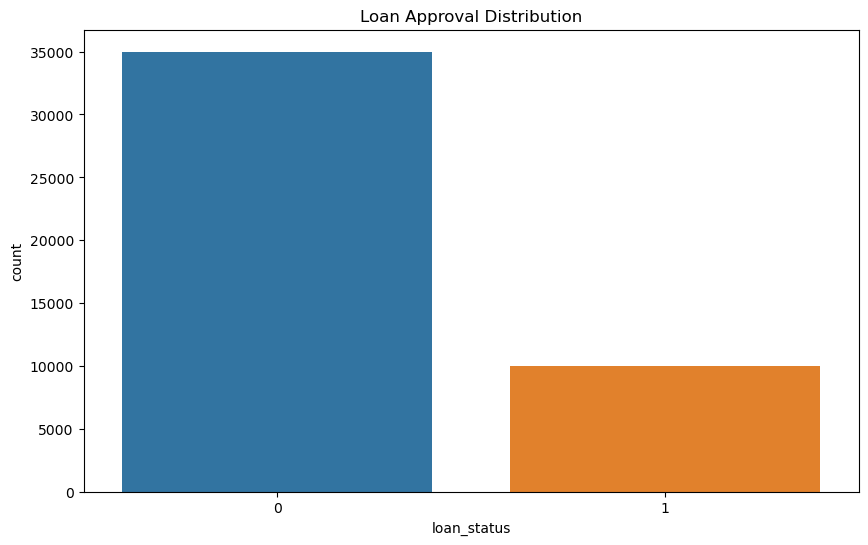

loan_status
0    0.777778
1    0.222222
Name: proportion, dtype: float64


In [4]:
plt.figure(figsize=(10,6))
sns.countplot(x='loan_status', data=df)
plt.title('Loan Approval Distribution')
plt.show()

print(df['loan_status'].value_counts(normalize=True))

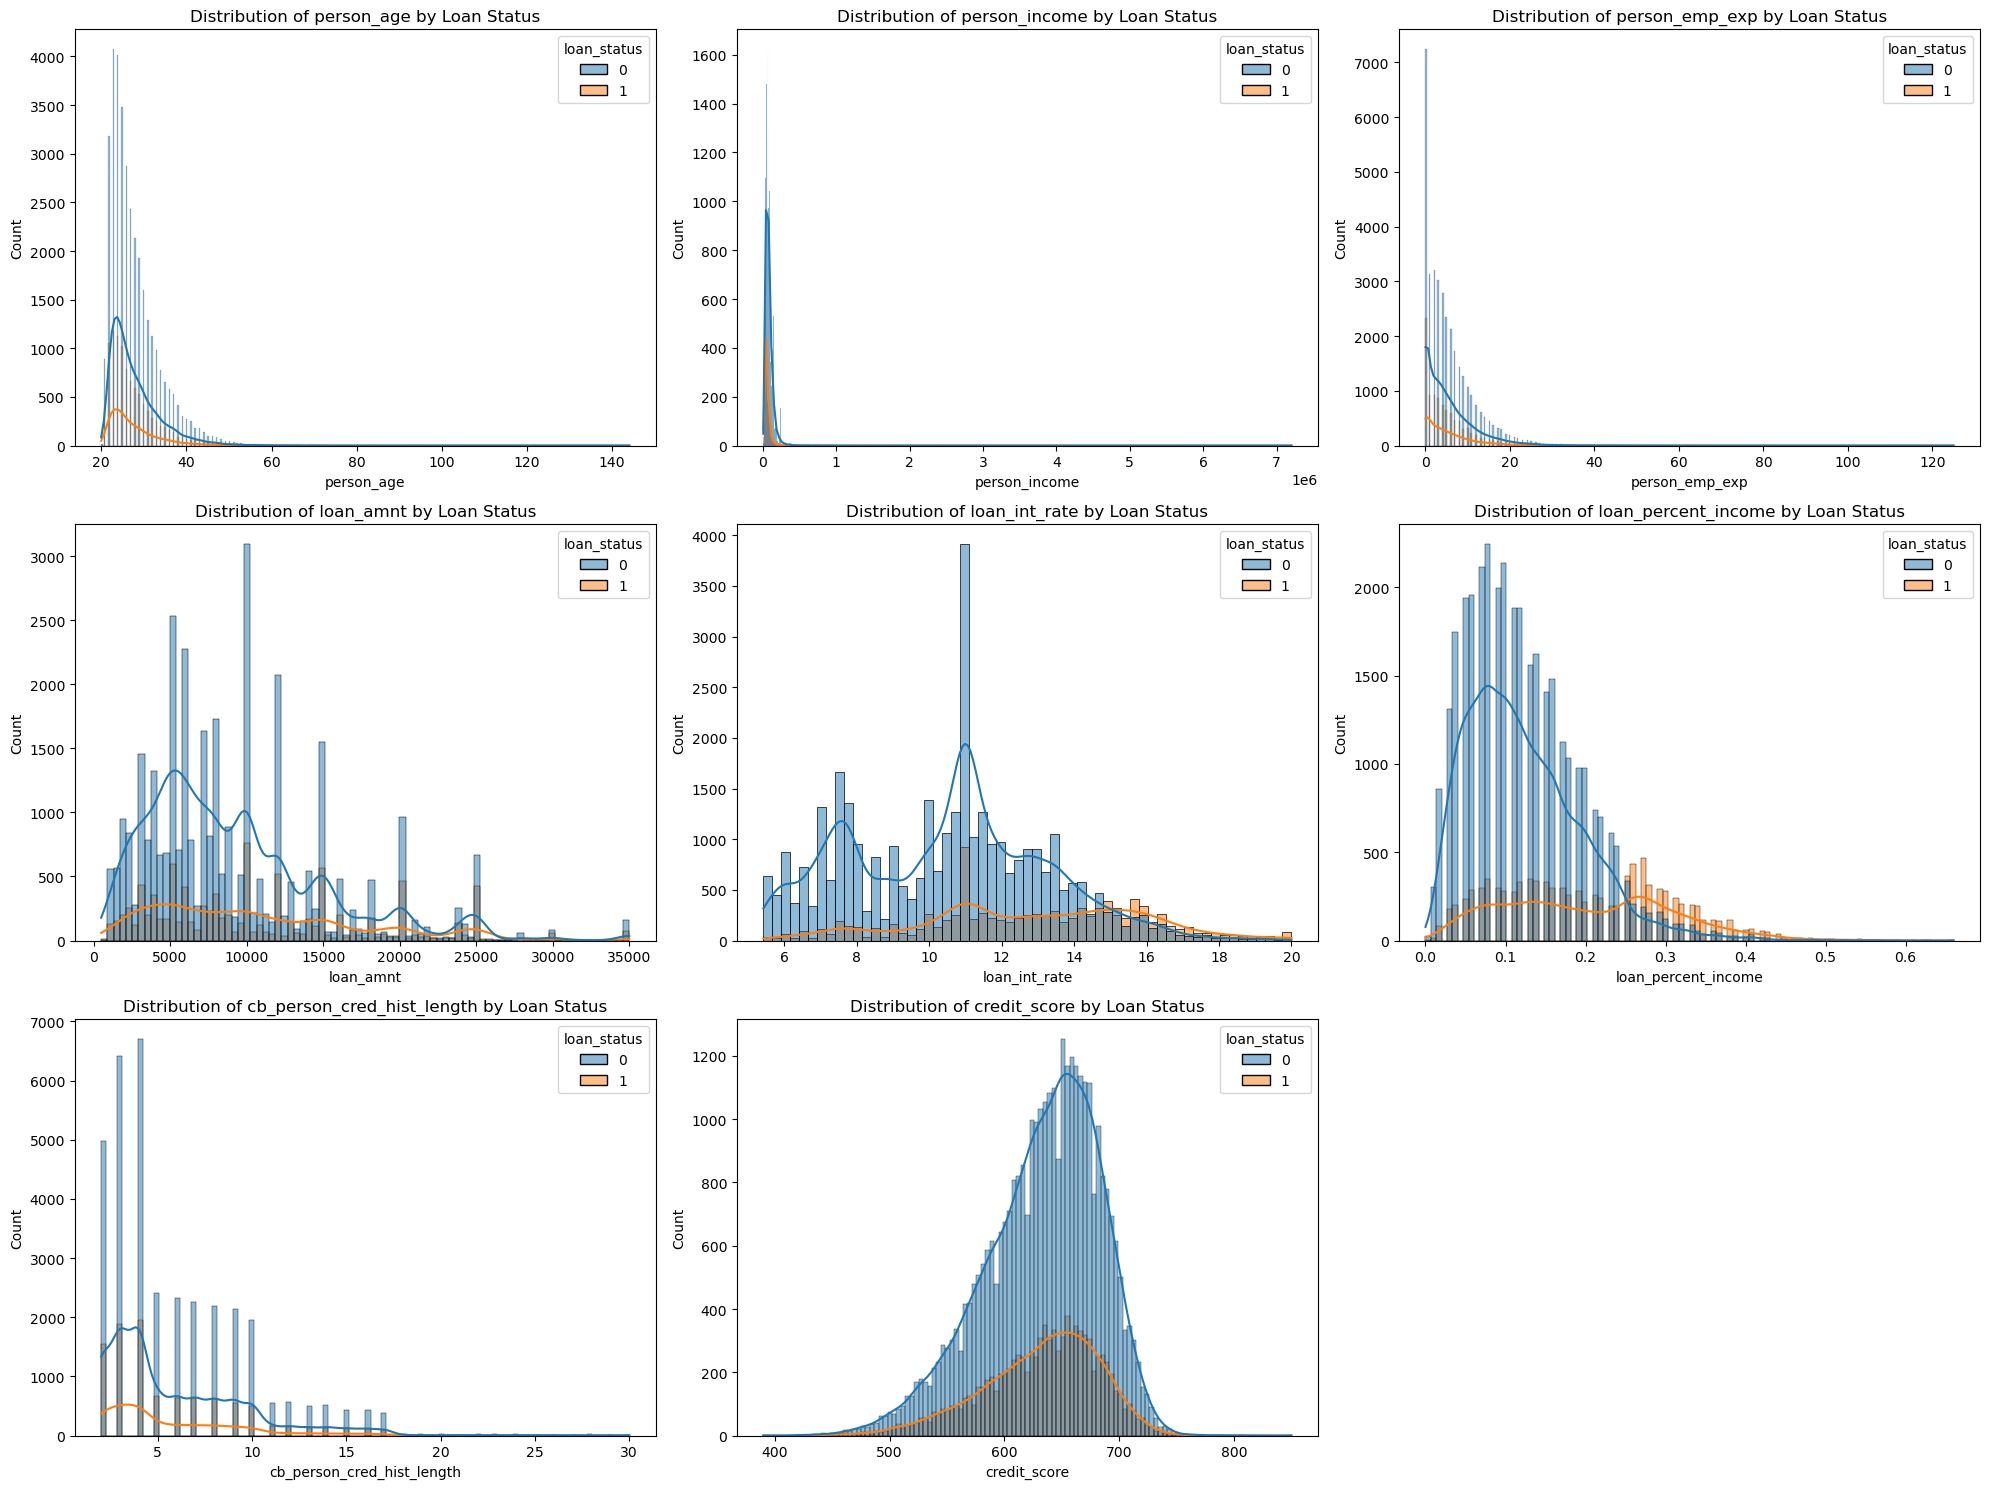

In [5]:
numeric_features = ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']

plt.figure(figsize=(20,15))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df, x=feature, hue='loan_status', kde=True)
    plt.title(f'Distribution of {feature} by Loan Status')
plt.tight_layout()
plt.show()

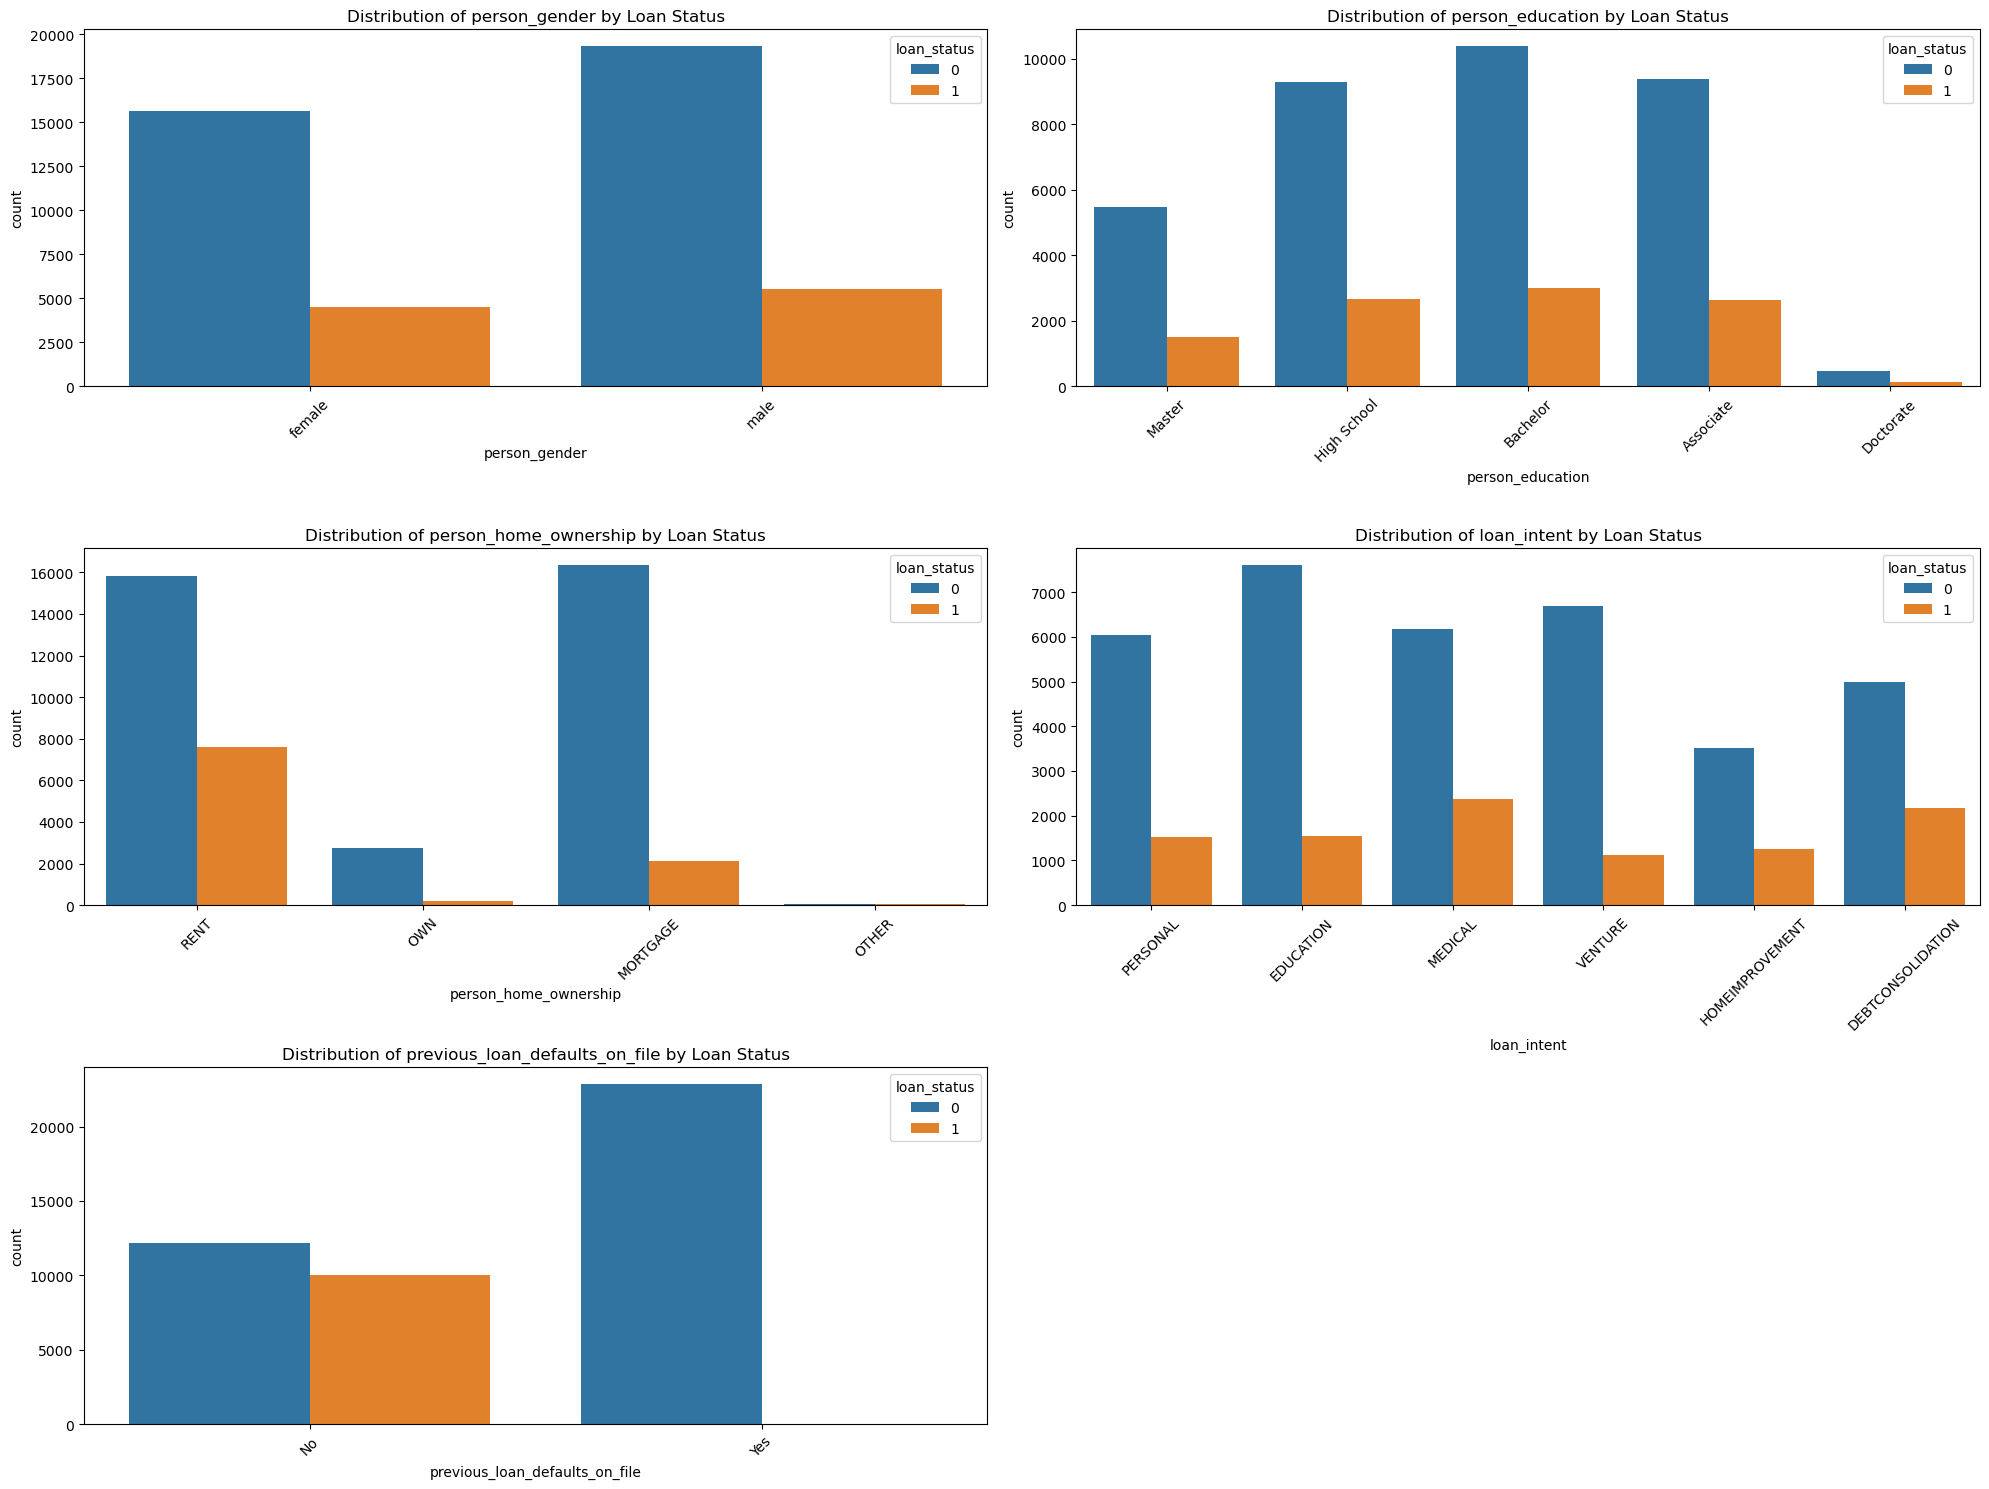

In [6]:
categorical_features = ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']

plt.figure(figsize=(20,15))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=df, x=feature, hue='loan_status')
    plt.title(f'Distribution of {feature} by Loan Status')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

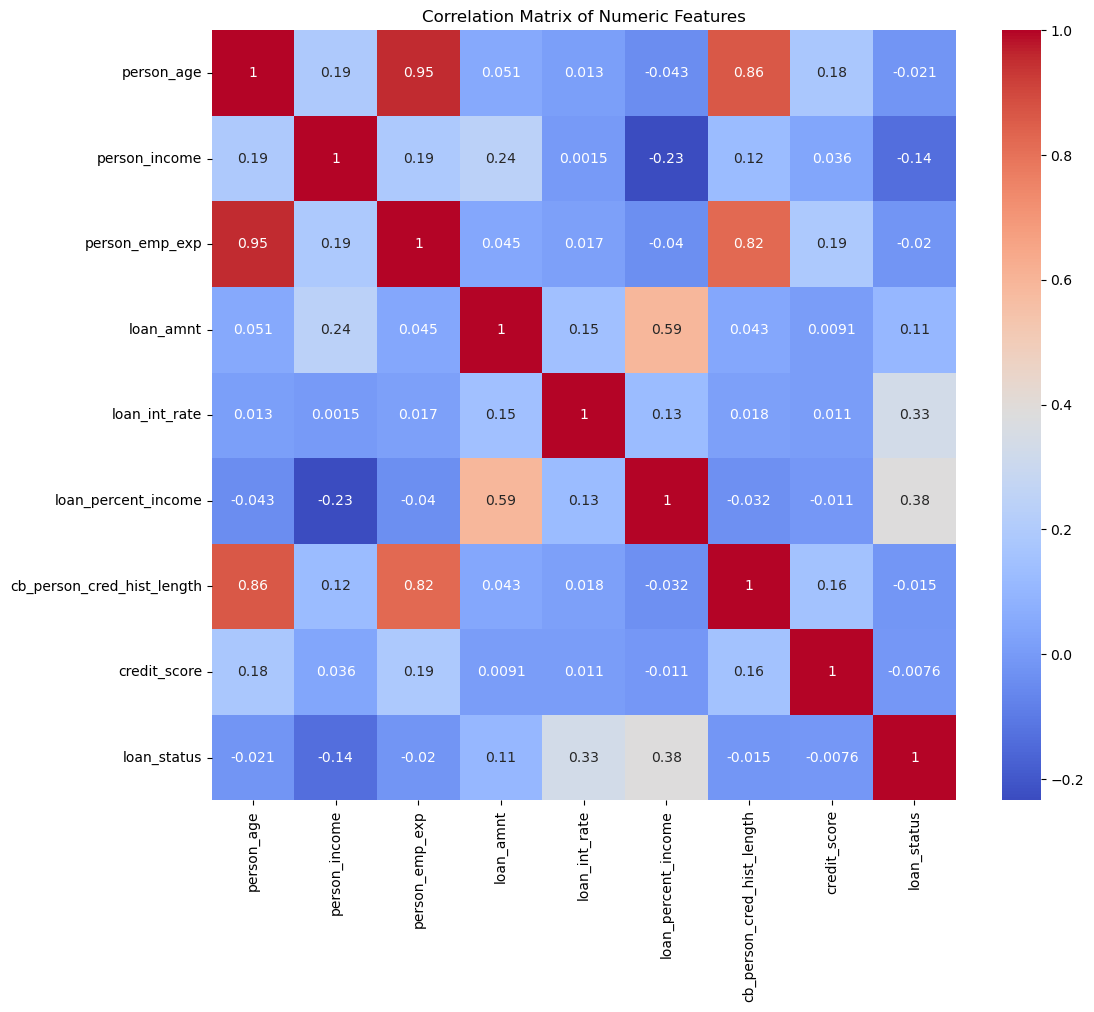

In [7]:
correlation_matrix = df[numeric_features + ['loan_status']].corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [8]:
df['age_group'] = pd.cut(df['person_age'], bins=[0, 25, 35, 45, 55, 100], labels=['18-25', '26-35', '36-45', '46-55', '55+'])

df['income_group'] = pd.qcut(df['person_income'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

df['credit_score_group'] = pd.cut(df['credit_score'], bins=[300, 580, 670, 740, 800, 850], labels=['Very Poor', 'Fair', 'Good', 'Very Good', 'Excellent'])

df['loan_to_income_ratio'] = df['loan_amnt'] / df['person_income']

df_encoded = pd.get_dummies(df, columns=categorical_features + ['age_group', 'income_group', 'credit_score_group'])

In [9]:
# 準備特徵和目標變量
X = df_encoded.drop(['loan_status', 'person_age', 'person_income', 'credit_score'], axis=1)
y = df_encoded['loan_status']

# 分割訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 標準化數值特徵
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 邏輯回歸模型
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

print("Logistic Regression Results:")
print(classification_report(y_test, lr_pred))
print("ROC AUC Score:", roc_auc_score(y_test, lr_model.predict_proba(X_test_scaled)[:,1]))

# 隨機森林模型
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("\nRandom Forest Results:")
print(classification_report(y_test, rf_pred))
print("ROC AUC Score:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1]))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      6990
           1       0.78      0.75      0.76      2010

    accuracy                           0.90      9000
   macro avg       0.85      0.84      0.85      9000
weighted avg       0.89      0.90      0.89      9000

ROC AUC Score: 0.9529558929245049

Random Forest Results:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      6990
           1       0.88      0.77      0.82      2010

    accuracy                           0.93      9000
   macro avg       0.91      0.87      0.89      9000
weighted avg       0.92      0.93      0.92      9000

ROC AUC Score: 0.9707030655022455


In [ ]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(10,8))
shap.summary_plot(shap_values[1], X_test)
plt.show()